In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('../..'))

if module_path not in sys.path:
    sys.path.append(module_path)


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from math import sqrt
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *

from helper import series_to_supervised
from model.mlp import mlp_layer

2024-02-02 14:57:17.138042: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [3]:
# import random

# random.seed(10)
# print(random.random())

In [4]:
data = pd.read_csv("../../data/pollution.csv", index_col=0)
data.fillna(0, inplace=True)
data.head()

,pollution,dew,temp,press,wnd_spd,snow,rain,NE,NW,SE,cv
date,,,,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,1.79,0,0,0,0,1,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2.68,0,0,0,0,1,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,3.57,0,0,0,0,1,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,5.36,1,0,0,0,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,6.25,2,0,0,0,1,0


In [5]:
data

,pollution,dew,temp,press,wnd_spd,snow,rain,NE,NW,SE,cv
date,,,,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,1.79,0,0,0,0,1,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2.68,0,0,0,0,1,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,3.57,0,0,0,0,1,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,5.36,1,0,0,0,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,6.25,2,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,231.97,0,0,0,1,0,0
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,237.78,0,0,0,1,0,0
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,242.70,0,0,0,1,0,0


In [6]:
data.columns

Index(['pollution', 'dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain', 'NE',
       'NW', 'SE', 'cv'],
      dtype='object')

(array([1.7727e+04, 1.0511e+04, 6.4690e+03, 3.7450e+03, 2.2240e+03,
        1.3270e+03, 7.5900e+02, 4.6700e+02, 2.8700e+02, 1.5400e+02,
        7.2000e+01, 2.5000e+01, 7.0000e+00, 8.0000e+00, 4.0000e+00,
        3.0000e+00, 4.0000e+00, 4.0000e+00, 0.0000e+00, 3.0000e+00]),
 array([  0. ,  49.7,  99.4, 149.1, 198.8, 248.5, 298.2, 347.9, 397.6,
        447.3, 497. , 546.7, 596.4, 646.1, 695.8, 745.5, 795.2, 844.9,
        894.6, 944.3, 994. ]),
 <BarContainer object of 20 artists>)

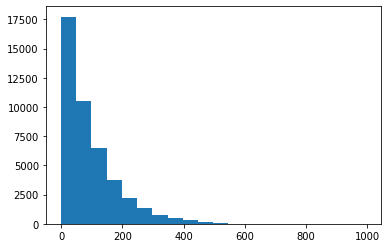

In [7]:
plt.hist(data['pollution'], bins=20)

In [8]:
np.percentile(data['pollution'], 95)

281.0

### Preprocess

In [9]:
values = data.values

# specify the number of lag hours
n_hours = 24*3
n_features = data.shape[-1]
k = 12
split1 = 0.7
split2 = 0.85

# frame as supervised learning
reframed = series_to_supervised(values, n_hours, k)
print("reframed.shape:", reframed.shape)

reframed.shape: (43717, 924)


In [10]:
# split into train and test sets
reframed_values = reframed.values
n_train_hours = int(len(reframed_values)*split1)
n_valid_hours = int(len(reframed_values)*split2)

train = reframed_values[:n_train_hours, :]
val = reframed_values[n_train_hours:n_valid_hours, :]
test = reframed_values[n_valid_hours:, :]


# split into input and outputs
n_obs = n_hours * n_features
feature_idx = 0
train_X, train_y = train[:, :n_obs], train[:, [n_obs + feature_idx + n_features * i for i in range(k)]]
val_X, val_y = val[:, :n_obs], val[:, [n_obs + feature_idx + n_features * i for i in range(k)]]
test_X, test_y = test[:, :n_obs], test[:, [n_obs + feature_idx + n_features * i for i in range(k)]]


print("train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape", 
      train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape
     )

train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape (30601, 792) (30601, 12) (6558, 792) (6558, 12) (6558, 792) (6558, 12)


In [11]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))

train_X = scaler.fit_transform(train_X)
train_y = scaler.fit_transform(train_y)

val_X = scaler.fit_transform(val_X)
val_y = scaler.fit_transform(val_y)

test_X = scaler.fit_transform(test_X)
test_y = scaler.fit_transform(test_y)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
val_X = val_X.reshape((val_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))

print("train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape", 
      train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape
     )

train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape (30601, 72, 11) (30601, 12) (6558, 72, 11) (6558, 12) (6558, 72, 11) (6558, 12)


### PM threshold

In [13]:
train_X_pm = train_X[:, 0, feature_idx]
print(train_X_pm.shape)

val_X_pm = val_X[:, 0, feature_idx]
print(val_X_pm.shape)

test_X_pm = test_X[:, 0, feature_idx]
print(test_X_pm.shape)

(30601,)
(6558,)
(6558,)


In [14]:
percentile = 95

merged_array = np.concatenate((train_X_pm, val_X_pm, test_X_pm))

percentile_pm = np.percentile(merged_array, percentile)

print("{}th Percentile of Daily Rain:".format(percentile), percentile_pm)

95th Percentile of Daily Rain: 0.33400402414486924


### train_X_filter

In [15]:
train_X_extreme = train_X[train_X_pm > percentile_pm]
print(train_X_extreme.shape)

train_y_extreme = train_y[train_X_pm > percentile_pm]
print(train_y_extreme.shape)

(848, 72, 11)
(848, 12)


In [16]:
train_X_normal = train_X[train_X_pm <= percentile_pm]
print(train_X_normal.shape)

train_y_normal = train_y[train_X_pm <= percentile_pm]
print(train_y_normal.shape)

(29753, 72, 11)
(29753, 12)


### val_X_filter

In [17]:
val_X_extreme = val_X[val_X_pm > percentile_pm]
print(val_X_extreme.shape)

val_y_extreme = val_y[val_X_pm > percentile_pm]
print(val_y_extreme.shape)

(752, 72, 11)
(752, 12)


In [18]:
val_X_normal = val_X[val_X_pm <= percentile_pm]
print(val_X_normal.shape)

val_y_normal = val_y[val_X_pm <= percentile_pm]
print(val_y_normal.shape)

(5806, 72, 11)
(5806, 12)


### test_X_filter

In [19]:
test_X_extreme = test_X[test_X_pm > percentile_pm]
print(test_X_extreme.shape)

test_y_extreme = test_y[test_X_pm > percentile_pm]
print(test_y_extreme.shape)

(581, 72, 11)
(581, 12)


In [20]:
test_X_normal = test_X[test_X_pm <= percentile_pm]
print(test_X_normal.shape)

test_y_normal = test_y[test_X_pm <= percentile_pm]
print(test_y_normal.shape)

(5977, 72, 11)
(5977, 12)


### Model & training

In [21]:
# ===== model parameters ======
mlp_unit1 = 128
mlp_unit2 = 128
mlp_unit3 = 64
mlp_unit4 = 64
mlp_unit5 = 32
mlp_unit6 = 32
mlp_unit7 = 16
mlp_unit8 = 16
dropout = 0.0
kernel_size = 2
pool_size = 2
learning_rate = 1e-4
decay_steps = 10000
decay_rate = 0.95
PATIENCE = 100
EPOCHS = 1000
BATCH = 512
opt_num = k
input_shape = train_X.shape[1:]

In [23]:
model = mlp_layer(input_shape=input_shape,
                   mlp_unit1=mlp_unit1,
                   mlp_unit2=mlp_unit2,
                   mlp_unit3=mlp_unit3,
                   mlp_unit4=mlp_unit4,
                   mlp_unit5=mlp_unit5,
                   mlp_unit6=mlp_unit6,
                   mlp_unit7=mlp_unit7,
                   mlp_unit8=mlp_unit8,
                   dropout=dropout,
                   masked_value=-1,
                   opt_num=opt_num
                  )
# model.summary()

In [24]:
# lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate, 
#                                                           decay_steps=decay_steps,
#                                                           decay_rate=decay_rate)

# model.compile(optimizer=Adam(learning_rate=lr_schedule),
#               loss='mse',
#               metrics=['mae']
#              )

model.compile(optimizer='adam',
              loss='mse',
              metrics=['mae']
             )


es = EarlyStopping(monitor='val_mae', mode='min', verbose=2, patience=PATIENCE)
mc = ModelCheckpoint('../../saved_models_mlp/pm_N.h5', 
                     monitor='val_mae', 
                     mode='min', 
                     verbose=2, 
                     save_best_only=True
                    )


model.fit(train_X_normal, train_y_normal,
          validation_data=(val_X_normal, val_y_normal),
          epochs=EPOCHS,
          batch_size=BATCH,
          verbose=2,
          shuffle=True,
          callbacks=[es, mc]
         )

2024-02-02 14:59:41.259504: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-02-02 14:59:41.260390: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 1700105000 Hz


Epoch 1/1000


2024-02-02 14:59:42.691132: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


59/59 - 4s - loss: 0.0069 - mae: 0.0607 - val_loss: 0.0109 - val_mae: 0.0723

Epoch 00001: val_mae improved from inf to 0.07229, saving model to ../../saved_models_mlp/pm_N.h5
Epoch 2/1000
59/59 - 1s - loss: 0.0044 - mae: 0.0459 - val_loss: 0.0096 - val_mae: 0.0667

Epoch 00002: val_mae improved from 0.07229 to 0.06672, saving model to ../../saved_models_mlp/pm_N.h5
Epoch 3/1000
59/59 - 1s - loss: 0.0039 - mae: 0.0423 - val_loss: 0.0089 - val_mae: 0.0637

Epoch 00003: val_mae improved from 0.06672 to 0.06366, saving model to ../../saved_models_mlp/pm_N.h5
Epoch 4/1000
59/59 - 1s - loss: 0.0037 - mae: 0.0412 - val_loss: 0.0089 - val_mae: 0.0668

Epoch 00004: val_mae did not improve from 0.06366
Epoch 5/1000
59/59 - 1s - loss: 0.0037 - mae: 0.0410 - val_loss: 0.0085 - val_mae: 0.0609

Epoch 00005: val_mae improved from 0.06366 to 0.06089, saving model to ../../saved_models_mlp/pm_N.h5
Epoch 6/1000
59/59 - 1s - loss: 0.0035 - mae: 0.0397 - val_loss: 0.0085 - val_mae: 0.0613

Epoch 00006: 

59/59 - 1s - loss: 0.0020 - mae: 0.0310 - val_loss: 0.0114 - val_mae: 0.0716

Epoch 00056: val_mae did not improve from 0.05977
Epoch 57/1000
59/59 - 1s - loss: 0.0019 - mae: 0.0304 - val_loss: 0.0117 - val_mae: 0.0722

Epoch 00057: val_mae did not improve from 0.05977
Epoch 58/1000
59/59 - 1s - loss: 0.0018 - mae: 0.0300 - val_loss: 0.0123 - val_mae: 0.0741

Epoch 00058: val_mae did not improve from 0.05977
Epoch 59/1000
59/59 - 1s - loss: 0.0018 - mae: 0.0298 - val_loss: 0.0131 - val_mae: 0.0769

Epoch 00059: val_mae did not improve from 0.05977
Epoch 60/1000
59/59 - 1s - loss: 0.0018 - mae: 0.0301 - val_loss: 0.0129 - val_mae: 0.0762

Epoch 00060: val_mae did not improve from 0.05977
Epoch 61/1000
59/59 - 1s - loss: 0.0018 - mae: 0.0296 - val_loss: 0.0142 - val_mae: 0.0800

Epoch 00061: val_mae did not improve from 0.05977
Epoch 62/1000
59/59 - 1s - loss: 0.0018 - mae: 0.0302 - val_loss: 0.0132 - val_mae: 0.0771

Epoch 00062: val_mae did not improve from 0.05977
Epoch 63/1000
59/59 

59/59 - 1s - loss: 0.0011 - mae: 0.0234 - val_loss: 0.0193 - val_mae: 0.0932

Epoch 00114: val_mae did not improve from 0.05977
Epoch 115/1000
59/59 - 1s - loss: 0.0011 - mae: 0.0231 - val_loss: 0.0203 - val_mae: 0.0960

Epoch 00115: val_mae did not improve from 0.05977
Epoch 116/1000
59/59 - 1s - loss: 0.0011 - mae: 0.0232 - val_loss: 0.0199 - val_mae: 0.0940

Epoch 00116: val_mae did not improve from 0.05977
Epoch 00116: early stopping
